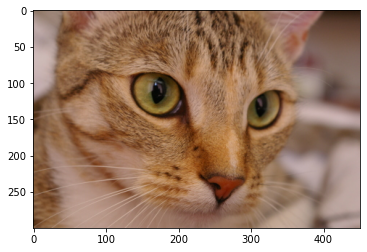

In [1]:
# Lodz University of Technology
# 2022-23 Image Processing Assignment 5
# @Ahmet Galip Sengun - 904261
# November 2022

import skimage
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Load image
img = skimage.data.chelsea()

plt.imshow(img)

# Task 1

Text(0.5, 1.0, '10% noised image')

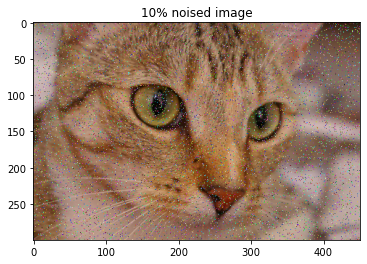

In [2]:
import random

noised_img = img.copy()
p = 0.1
N = int(img.shape[0] * img.shape[1] * p)
for i in range(N):
    randx = random.randrange(img.shape[1])
    randy = random.randrange(img.shape[0])
    randomRGB = random.sample(range(256), 3)
    noised_img[randy, randx] = randomRGB
plt.imshow(noised_img)
plt.title(f"{p*100:.0f}% noised image")

# Task 2

In [3]:
def nmse(img1, img2):
    
    img1, img2 = img1.astype(np.float64), img2.astype(np.float64)
    up, down = 0, 0
    for i in range(3):
        up += np.sum(np.square(img1[:,:,i] - img2[:,:,i])) 
        down += np.sum(np.square(img1[:,:,i]))
    return up/down

In [4]:
nmse(img, noised_img)

0.04681102113889414

In [5]:
def median_filter(img, footprint):
    filt = skimage.filters.median(img, footprint)
    return filt

# Task 3

In [6]:
def extend_image(img):
    bordersize = 1
    border = cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_REPLICATE,
    )
    return border

In [7]:
def dist(a, b):
    squared_dist = np.sum((a-b)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist

In [8]:
def VMF(img, i, j):
    
    """[
        p1
    p4  p0  p2
        p3
        
           [0,1]
    [1,0]  [1,1]  [1,2]
           [2,1]
        
    ]
    """
    p0 = img[i+1,j+1]
    p1 = img[i,j+1]
    p2 = img[i+1,j+2]
    p3 = img[i+2,j+1]
    p4 = img[i+1,0]
    
    d01 = dist(p0, p1)
    d02 = dist(p0, p2)
    d03 = dist(p0, p3)
    d04 = dist(p0, p4)
    d12 = dist(p1, p2)
    d13 = dist(p1, p3)
    d14 = dist(p1, p4)
    d23 = dist(p2, p3)
    d24 = dist(p2, p4)
    d34 = dist(p3, p4)
    
    sum0 = d01 + d02 + d03 + d04
    sum1 = d01 + d12 + d13 + d14
    sum2 = d02 + d12 + d23 + d24
    sum3 = d03 + d13 + d23 + d34
    sum4 = d04 + d14 + d24 + d34
    summin = sum0
    
    if(summin>sum1):
        p0 = p1
        summin = sum1
    if(summin>sum2):
        p0 = p2
        summin = sum2
    if(summin>sum3):
        p0 = p3
        summin = sum3
    if(summin>sum4):
        p0 = p4
        
    return p0
    
    """sum0 = ||p0 - p1|| + ||p0 - p2|| + ||p0 - p3|| + ||p0 - p4||;
    sum1 = ||p0 - p1|| + ||p1 - p2|| + ||p1 - p3|| + ||p1 - p4||;
    sum2 = ||p0 - p2|| + ||p1 - p2|| + ||p2 - p3|| + ||p2 - p4||;
    sum3 = ||p0 - p3|| + ||p1 - p3|| + ||p2 - p3|| + ||p3 - p4||;
    sum4 = ||p0 - p4|| + ||p1 - p4|| + ||p2 - p4|| + ||p3 - p4||;
    summin = sum0;
    if(summin>sum1){ p0 = p1; summin = sum1; } 
    if(summin>sum2){ p0 = p2; summin = sum2; }
    if(summin>sum3){ p0 = p3; summin = sum3; }
    if(summin>sum4){ p0 = p4;}"""

In [9]:
def convole2d(img, method):
    if method == "VMF":
        extended = extend_image(img)
        output = img.copy()
        for i in range(len(extended)-2):
            for j in range(len(extended[0])-2):
                temp = VMF(extended, i, j)
                output[i,j] = temp
        return output
    elif method == "FMVMF":
        extended = extend_image(img)
        norm = (extended - np.min(extended)) / (np.max(extended) - np.min(extended))
        output = img.copy()
        
        for i in range(len(norm)-2):
            for j in range(len(norm[0])-2):
                temp = FMVMF(norm, i, j)
                output[i,j] = temp
        return output
    else:
        pass

Text(0.5, 1.0, 'Denoised Image VMF')

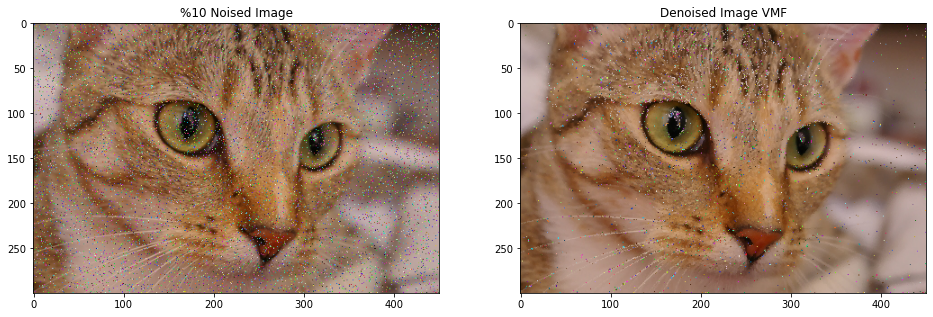

In [10]:
img_ = convole2d(noised_img, "VMF")
fig, ax = plt.subplots(1, 2, figsize = (16,8))
ax[0].imshow(noised_img)
ax[0].set_title("%10 Noised Image")

ax[1].imshow(img_)
ax[1].set_title("Denoised Image VMF")

In [11]:
def normalize_data(data):
    return data / np.linalg.norm(data)

In [12]:
def FMVMF(img, i, j):
    p0 = img[i+1,j+1]
    p1 = img[i,j+1]
    p2 = img[i+1,j+2]
    p3 = img[i+2,j+1]
    p4 = img[i+1,0]

    d01 = dist(p0, p1)
    d02 = dist(p0, p2)
    d03 = dist(p0, p3)
    d04 = dist(p0, p4)
    d12 = dist(p1, p2)
    d13 = dist(p1, p3)
    d14 = dist(p1, p4)
    d23 = dist(p2, p3)
    d24 = dist(p2, p4)
    d34 = dist(p3, p4)
    
    beta = 0.75
    
    sum0 = d01 + d02 + d03 + d04 - beta
    sum1 = d12 + d13 + d14
    sum2 = d12 + d23 + d24
    sum3 = d13 + d23 + d34
    sum4 = d14 + d24 + d34
    
    summin = sum1
    ptmp = p1
    
    if(summin>sum2):
        ptmp = p2
        summin = sum2
    if(summin>sum3):
        ptmp = p3
        summin = sum3
    if(summin>sum4):
        ptmp = p4
        summin = sum4
    if(sum0-beta<summin):
        p0 = ptmp
        
    return p0*256

Text(0.5, 1.0, 'Denoised Image FMVMF')

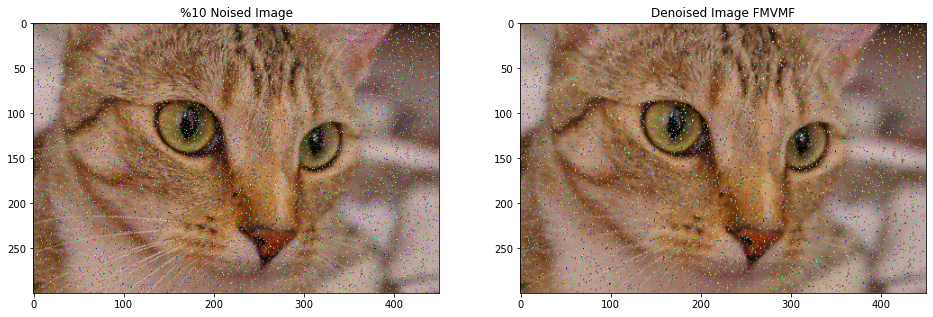

In [15]:
img_ = convole2d(noised_img, "FMVMF")
fig, ax = plt.subplots(1, 2, figsize = (16,8))
ax[0].imshow(noised_img)
ax[0].set_title("%10 Noised Image")

ax[1].imshow(img_)
ax[1].set_title("Denoised Image FMVMF")

In [14]:
def PNN_VMF(img, i, j):
    pass